In [41]:
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
import numpy as np
import pandas as pd
import json
import os
import my_utils
import re

In [42]:
DPI=300

In [43]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
expirements_logs = os.path.join(logs_directory, "logs_2024-05-12T10:18:55")
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")
testcase = "throughput" # "throughput" or "goodput"

In [44]:
def extract_info_from_file(filename: str) -> tuple[int, int]:
    """
    tx_packets | rx_packets
    """
    with open(filename, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        return pd.DataFrame()
    total_recv, total_sent = 0, 0
    for line in lines:
        line = line.strip()
        if re.match(r".*connection close.*", line) is None:
            continue
        matches = re.findall(r"recv=[^\s]+", line)
        for match in matches:
            total_recv += int(match.split("=")[1])
        matches = re.findall(r"sent=[^\s]+", line)
        for match in matches:
            total_sent += int(match.split("=")[1])
    return total_sent, total_recv

def extract_goodput_data_for_client(role_logs: str) -> int:
    trace_files = [f for f in os.listdir(role_logs) if f.startswith("client.log")]
    if len(trace_files) == 0:
        return pd.DataFrame(columns=["goodput", "nb_paths", "implementation"])
    elif len(trace_files) > 1:
        raise Exception("More than one client log file found")
    return extract_info_from_file(os.path.join(role_logs, trace_files[0]))

def extract_goodput_data_per_run(run_logs: str, extract_nb_paths) -> pd.DataFrame:
    if extract_nb_paths is None:
        raise Exception("extract_nb_paths is None")
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    elapsed_seconds = my_utils.get_transfer_time_client(os.path.join(run_logs, "client", "time.json"))
    total_tx, total_rx= extract_goodput_data_for_client(os.path.join(run_logs, "client"))
    return pd.DataFrame({"packets_tx": total_tx, "packets_rx": total_rx, "nb_paths": nb_paths}, index=[0])

def extract_goodput_per_testcase(testcase_logs: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["packets_tx", "packets_rx", "nb_paths"])
    for run in runs_dirs:
        df_run = extract_goodput_data_per_run(os.path.join(testcase_logs, run), extract_nb_paths)
        df = pd.concat([df, df_run], ignore_index=True)
    return df

def extract_goodput_impl(implementation_logs: str, impl_name: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ goodput| nb_paths | implementation
    """
    df = extract_goodput_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths)
    df["implementation"] = impl_name
    return df

def extract_goodput_from_info_logs(logs: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["packets_tx", "packets_rx", "nb_paths", "implementation"])
    for logs_dir in logs:
        logs_dir = os.path.join(logs_directory, logs_dir)
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name in ["mcmpquic", "mpquic"]:
                df_ret = extract_goodput_impl(os.path.join(logs_dir, implemantation_logs), impl_name, my_utils.mcmpquic_extract_nb_paths)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception(f"Unknown implementation {impl_name}")
    return df

In [45]:
goodput_df = extract_goodput_from_info_logs(["logs_2024-05-23T10:47:38", "logs_2024-05-23T15:10:07"])
goodput_df

,packets_tx,packets_rx,nb_paths,implementation
0,395424,13592040,5,mpquic
1,171280,13400270,4,mpquic
2,476108,12341660,8,mpquic
3,331612,12079548,10,mpquic
4,377836,12281780,12,mpquic
...,...,...,...,...
315,251280,30483825,15,mcmpquic
316,228783,30023016,16,mcmpquic
317,274905,30946053,15,mcmpquic
318,275442,29686993,16,mcmpquic


In [70]:
def plot_packets_info(ax: plt.Axes, df: pd.DataFrame):
    """Plots the goodput data in a DataFrame as error bars."""
    implementations = df["implementation"].unique()
    colors = [my_utils.get_color_for_impl(impl) for impl in implementations]
    all_nb_paths = sorted(df["nb_paths"].unique())
    for impl, color in zip(implementations, colors):
        tx_data = []; tx_err = []; rx_data = []; rx_err = []
        for nb_paths in all_nb_paths:
            df_impl = df[(df["implementation"] == impl) & (df["nb_paths"] == nb_paths)]
            tx_df = df_impl["packets_tx"]
            if len(tx_df) == 0:
                tx_data.append(0)
                tx_err.append(0)
            else:
                tx_data.append(df_impl["packets_tx"].mean())
                tx_err.append(df_impl["packets_tx"].std())
            rx_df = df_impl["packets_rx"]
            if len(rx_df) == 0:
                rx_data.append(0)
                rx_err.append(0)
            else:
                rx_data.append(df_impl["packets_rx"].mean())
                rx_err.append(df_impl["packets_rx"].std())
        ax.errorbar(all_nb_paths, tx_data, yerr=tx_err, fmt="p", color=color, label=f"tx {impl}", elinewidth=1, capsize=2)
        #ax.errorbar(all_nb_paths, rx_data, yerr=rx_err, fmt="x", color=color, label=f"rx {impl}")
    ax.set_xlabel("Number of paths")
    ax.set_ylabel("Number of packets")
    ax.grid(which='major', color='black', linewidth=.4, alpha=0.2, linestyle="dashed")  # Show the major grid
    ax.legend(edgecolor='black', fancybox=False, shadow=False, framealpha=1)
    ax.set_xticks(all_nb_paths, all_nb_paths)

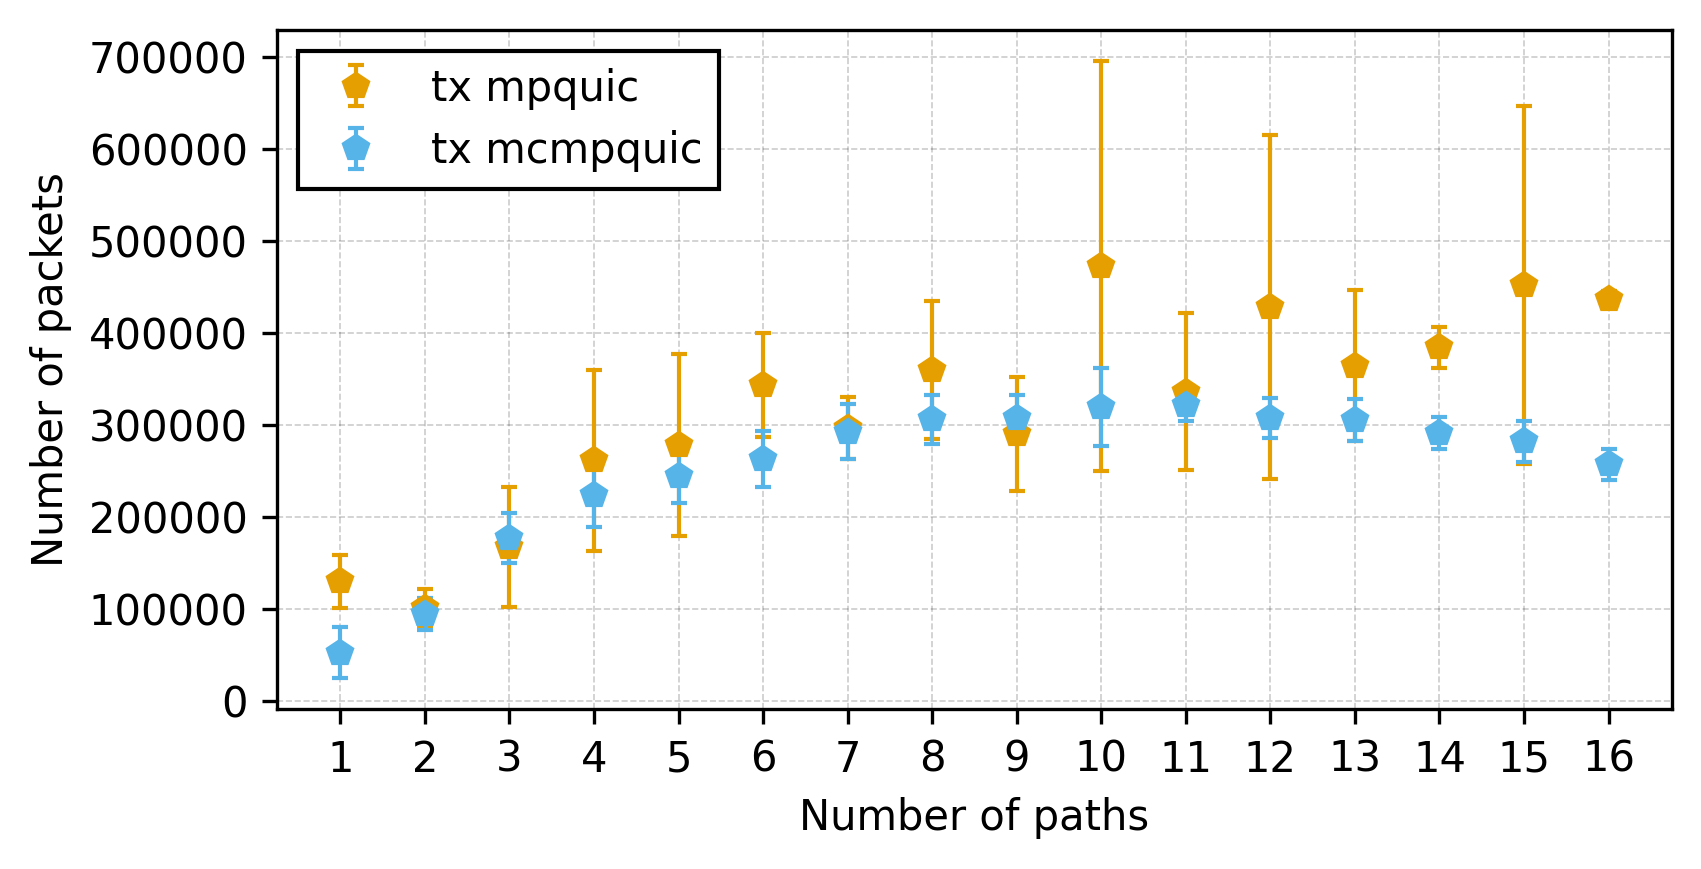

In [71]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 3), dpi=DPI)
plot_packets_info(ax, goodput_df.copy())